In [1]:
import os
from datetime import datetime
import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

from pathlib import Path
from copy import copy
from typing import Union, Optional

import openpyxl
from openpyxl import load_workbook
from openpyxl.utils import get_column_letter
from openpyxl.styles import Font, PatternFill, Alignment
from openpyxl.formatting.rule import Rule
from openpyxl.styles.differential import DifferentialStyle

In [16]:
def copy_excel_cell_range(
        src_ws: openpyxl.worksheet.worksheet.Worksheet,
        min_row: int = None,
        max_row: int = None,
        min_col: int = None,
        max_col: int = None,
        tgt_ws: openpyxl.worksheet.worksheet.Worksheet = None,
        tgt_min_row: int = 1,
        tgt_min_col: int = 1,
        with_style: bool = True
) -> openpyxl.worksheet.worksheet.Worksheet:
    """
    copies all cells from the source worksheet [src_ws] starting from [min_row] row
    and [min_col] column up to [max_row] row and [max_col] column
    to target worksheet [tgt_ws] starting from [tgt_min_row] row
    and [tgt_min_col] column.

    @param src_ws:  source worksheet
    @param min_row: smallest row index in the source worksheet (1-based index)
    @param max_row: largest row index in the source worksheet (1-based index)
    @param min_col: smallest column index in the source worksheet (1-based index)
    @param max_col: largest column index in the source worksheet (1-based index)
    @param tgt_ws:  target worksheet.
                    If None, then the copy will be done to the same (source) worksheet.
    @param tgt_min_row: target row index (1-based index)
    @param tgt_min_col: target column index (1-based index)
    @param with_style:  whether to copy cell style. Default: True

    @return: target worksheet object
    """
    if tgt_ws is None:
        tgt_ws = src_ws

    # https://stackoverflow.com/a/34838233/5741205
    for row in src_ws.iter_rows(min_row=min_row, max_row=max_row,
                                min_col=min_col, max_col=max_col):
        for cell in row:
            tgt_cell = tgt_ws.cell(
                row=cell.row + tgt_min_row - 1,
                column=cell.col_idx + tgt_min_col - 1,
                value=cell.value
            )
            if with_style and cell.has_style:
                # tgt_cell._style = copy(cell._style)
                tgt_cell.font = copy(cell.font)
                tgt_cell.border = copy(cell.border)
                tgt_cell.fill = copy(cell.fill)
                tgt_cell.number_format = copy(cell.number_format)
                tgt_cell.protection = copy(cell.protection)
                tgt_cell.alignment = copy(cell.alignment)
    return tgt_ws

In [17]:


def append_df_to_excel(
        filename: Union[str, Path],
        df: pd.DataFrame,
        sheet_name: str = 'Sheet1',
        startrow: Optional[int] = None,
        max_col_width: int = 30,
        autofilter: bool = False,
        fmt_int: str = "#,##0",
        fmt_float: str = "#,##0.00",
        fmt_date: str = "yyyy-mm-dd",
        fmt_datetime: str = "yyyy-mm-dd hh:mm",
        truncate_sheet: bool = False,
        storage_options: Optional[dict] = None,
        **to_excel_kwargs
) -> None:
    """
    Append a DataFrame [df] to existing Excel file [filename]
    into [sheet_name] Sheet.
    If [filename] doesn't exist, then this function will create it.

    @param filename: File path or existing ExcelWriter
                     (Example: '/path/to/file.xlsx')
    @param df: DataFrame to save to workbook
    @param sheet_name: Name of sheet which will contain DataFrame.
                       (default: 'Sheet1')
    @param startrow: upper left cell row to dump data frame.
                     Per default (startrow=None) calculate the last row
                     in the existing DF and write to the next row...
    @param max_col_width: maximum column width in Excel. Default: 40
    @param autofilter: boolean - whether add Excel autofilter or not. Default: False
    @param fmt_int: Excel format for integer numbers
    @param fmt_float: Excel format for float numbers
    @param fmt_date: Excel format for dates
    @param fmt_datetime: Excel format for datetime's
    @param truncate_sheet: truncate (remove and recreate) [sheet_name]
                           before writing DataFrame to Excel file
    @param storage_options: dict, optional
        Extra options that make sense for a particular storage connection, e.g. host, port,
        username, password, etc., if using a URL that will be parsed by fsspec, e.g.,
        starting “s3://”, “gcs://”.
    @param to_excel_kwargs: arguments which will be passed to `DataFrame.to_excel()`
                            [can be a dictionary]
    @return: None

    Usage examples:

    >>> append_df_to_excel('/tmp/test.xlsx', df, autofilter=True,
                           freeze_panes=(1,0))

    >>> append_df_to_excel('/tmp/test.xlsx', df, header=None, index=False)

    >>> append_df_to_excel('/tmp/test.xlsx', df, sheet_name='Sheet2',
                           index=False)

    >>> append_df_to_excel('/tmp/test.xlsx', df, sheet_name='Sheet2',
                           index=False, startrow=25)

    >>> append_df_to_excel('/tmp/test.xlsx', df, index=False,
                           fmt_datetime="dd.mm.yyyy hh:mm")

    (c) [MaxU](https://stackoverflow.com/users/5741205/maxu?tab=profile)
    """
    def set_column_format(ws, column_letter, fmt):
        for cell in ws[column_letter]:
            cell.number_format = fmt
    filename = Path(filename)
    file_exists = filename.is_file()
    # process parameters
    # calculate first column number
    # if the DF will be written using `index=True`, then `first_col = 2`, else `first_col = 1`
    first_col = int(to_excel_kwargs.get("index", True)) + 1
    # ignore [engine] parameter if it was passed
    if 'engine' in to_excel_kwargs:
        to_excel_kwargs.pop('engine')
    # save content of existing sheets
    if file_exists:
        wb = load_workbook(filename)
        sheet_names = wb.sheetnames
        sheet_exists = sheet_name in sheet_names
        sheets = {ws.title: ws for ws in wb.worksheets}

    with pd.ExcelWriter(
        filename.with_suffix(".xlsx"),
        engine="openpyxl",
        mode="a" if file_exists else "w",
        if_sheet_exists="new" if file_exists else None,
        date_format=fmt_date,
        datetime_format=fmt_datetime,
        storage_options=storage_options
    ) as writer:
        if file_exists:
            # try to open an existing workbook
            writer.book = wb
            # get the last row in the existing Excel sheet
            # if it was not specified explicitly
            if startrow is None and sheet_name in writer.book.sheetnames:
                startrow = writer.book[sheet_name].max_row
            # truncate sheet
            if truncate_sheet and sheet_name in writer.book.sheetnames:
                # index of [sheet_name] sheet
                idx = writer.book.sheetnames.index(sheet_name)
                # remove [sheet_name]
                writer.book.remove(writer.book.worksheets[idx])
                # create an empty sheet [sheet_name] using old index
                writer.book.create_sheet(sheet_name, idx)
            # copy existing sheets
            writer.sheets = sheets
        else:
            # file doesn't exist, we are creating a new one
            startrow = 0

        # write out the DataFrame to an ExcelWriter
        df.to_excel(writer, sheet_name=sheet_name, **to_excel_kwargs)
        worksheet = writer.sheets[sheet_name]

        if autofilter:
            worksheet.auto_filter.ref = worksheet.dimensions

        for xl_col_no, dtyp in enumerate(df.dtypes, first_col):
            col_no = xl_col_no - first_col
            width = max(df.iloc[:, col_no].astype(str).str.len().max(),
                        len(df.columns[col_no]) + 6)
            width = min(max_col_width, width)
            column_letter = get_column_letter(xl_col_no)
            worksheet.column_dimensions[column_letter].width = width
            if np.issubdtype(dtyp, np.integer):
                set_column_format(worksheet, column_letter, fmt_int)
            if np.issubdtype(dtyp, np.floating):
                set_column_format(worksheet, column_letter, fmt_float)

    if file_exists and sheet_exists:
        # move (append) rows from new worksheet to the `sheet_name` worksheet
        wb = load_workbook(filename)
        # retrieve generated worksheet name
        new_sheet_name = set(wb.sheetnames) - set(sheet_names)
        if new_sheet_name:
            new_sheet_name = list(new_sheet_name)[0]
        # copy rows written by `df.to_excel(...)` to
        copy_excel_cell_range(
            src_ws=wb[new_sheet_name],
            tgt_ws=wb[sheet_name],
            tgt_min_row=startrow + 1,
            with_style=True
        )
        # remove new (generated by Pandas) worksheet
        del wb[new_sheet_name]
        wb.save(filename)
        wb.close()

In [18]:
def insertDataIntoDB(dbName, cur):
    # Replaces any spaces, &, - characters into underscore
    TABLENAME_CLEANING_CHARACTERS = [(" ", "_"),("&", "_"),("-", "_")]
    
       
    beforeFile = open(COMPARISON_FILE_PATH + "/" + dbName + BEFORE_IMPLMENT_KEYWORD + COMPARISON_FILE_EXTENSION, "r")
    afterFile = open(COMPARISON_FILE_PATH + "/" + dbName + AFTER_IMPLMENT_KEYWORD + COMPARISON_FILE_EXTENSION, "r")
    beforeDbData = beforeFile.read().split("\n\n")
    afterDbData = afterFile.read().split("\n\n")
    
    
    for index, table in enumerate(beforeDbData + afterDbData):
        
        if index < len(beforeDbData):
            tableSuffix = BEFORE_IMPLMENT_KEYWORD
        else:
            tableSuffix = AFTER_IMPLMENT_KEYWORD

        # Get the data of individual tables
        tableInfo = table.split("\n")
        
        if tableInfo != '' and len(tableInfo) > 1:
            
            # Cleaning and storing the table name
            tableName = tableInfo[0][len("*** ") : -len(" ***")]
            tableName = tableName + "_" + tableSuffix
            for clean_char in TABLENAME_CLEANING_CHARACTERS:
                tableName = tableName.replace(clean_char[0], clean_char[1])
            
            # Cleaning and storing the table columns
            tableColumns = list()
            for column in tableInfo[1].split("\t"):
                tableColumns.append(column.replace(".", "_"))
            tableColumns = tuple(tableColumns)
            
            # Creating tables and execution
            tableCreationQuery = 'CREATE TABLE {table_name} {table_columns}'
            tableCreationQuery = tableCreationQuery.format(table_name = tableName, table_columns = tableColumns)
            try:
                cur.execute(tableCreationQuery)
            except sqlite3.OperationalError:
                pass
            
            for data in tableInfo[2:]:
                
                # Creating table data and execution
                row_data = tuple(data.split("\t"))
                tableDataInsertionQuery = 'INSERT INTO {table_name} VALUES {table_data}'
                tableDataInsertionQuery = tableDataInsertionQuery.format(table_name = tableName, table_data = row_data)
                cur.execute(tableDataInsertionQuery)
            
            con.commit()
            
    beforeFile.close()
    afterFile.close()

In [19]:
def create_result_df(con, tableName):
    beforeTable = tableName + "_" + BEFORE_IMPLMENT_KEYWORD
    afterTable = tableName + "_" + AFTER_IMPLMENT_KEYWORD
    
    # Get all the columns for the current table
    getColumnsQuery = "SELECT * FROM {table_name};".format(table_name = beforeTable)
    data = con.cursor().execute(getColumnsQuery)
    columns = [col[0] for col in data.description]
    
    # Custom and formatted columns query
    displayColumns1 = "b." + columns[0] + " AS before_date, a." + columns[0] + " AS after_date, "
    displayColumns2 = "a." + columns[0] + " AS before_date, b." + columns[0] + " AS after_Date, "
    for column in columns[1:-1]:
        displayColumns1 += "a." + column + ", "
        displayColumns2 += "a." + column + ", "
    displayColumns2 += "a." + columns[-1] + " AS count_before, b." + columns[-1] + " AS count_after"
    displayColumns1 += "b." + columns[-1] + " AS count_before, a." + columns[-1] + " AS count_after"
    
    # Join Condition query
    joinCondition = ""
    for column in columns[1:-2]:
        joinCondition += "a." + column + " = b." + column + " AND "
    joinCondition += "a." + columns[-2] + " = b." + columns[-2]
    
    # Combine the queries: display + join
    query1 = "SELECT {display_columns} from {after_table} AS a LEFT JOIN {before_table} AS b ON {join_condition}"
    query1 = query1.format(display_columns = displayColumns1, after_table = afterTable, before_table = beforeTable, join_condition = joinCondition)
    query2 = "SELECT {display_columns} from {before_table} AS a LEFT JOIN {after_table} AS b ON {join_condition}"
    query2 = query2.format(display_columns = displayColumns2, before_table = beforeTable, after_table = afterTable, join_condition = joinCondition)
    query = "{} UNION {}".format(query1, query2)
    
    # Data Cleaning
    new_df = pd.read_sql(query, con)
    new_df[["count_before","count_after"]] = new_df[["count_before","count_after"]].fillna(0)
    new_df[["count_before","count_after"]] = new_df[["count_before","count_after"]].applymap(int)
    new_df["Difference (after - before)"] = new_df["count_after"] - new_df["count_before"]
    # Sorting by the join condition columns
    new_df = new_df.sort_values(new_df.columns[2:-3].tolist())
    
    return new_df
    

In [20]:
dxf2 = DifferentialStyle(fill = PatternFill(bgColor = "FFC7CE"))# Red Fill
dxf = DifferentialStyle(fill = PatternFill(bgColor = "00CCFFCC"))# Green Fill
g = Rule(type = "expression", dxf = dxf2, stopIfTrue = True)
r = Rule(type = "expression", dxf = dxf, stopIfTrue = True)
mergedCellFont = Font(bold = True, color = "00FFFFFF")
mergedCellFill = PatternFill("solid", fgColor = "00003366")
mergedCellAlignment = Alignment(horizontal = "center", vertical = "center")

def write_to_excel_with_formatting(df, sheet_name):
    # Write and style the table name
    wb = load_workbook(RESULT_FILENAME)
    ws = wb[sheet_name]
    currentRow = ws.max_row + 2
    tableNameCell = "B" + str(currentRow)
    ws[tableNameCell] = sheet_name
    ws.merge_cells(tableNameCell + ":" + get_column_letter(df.shape[1] + 1) + str(currentRow))
    mergedCell = ws[tableNameCell]
    mergedCell.font = mergedCellFont
    mergedCell.fill = mergedCellFill
    mergedCell.alignment =mergedCellAlignment
    wb.save(RESULT_FILENAME)
    
    append_df_to_excel(filename = RESULT_FILENAME, df = df, sheet_name = sheet_name, startrow = currentRow, index = True)
    
    # Add styling to highlight the difference
    wb = load_workbook(RESULT_FILENAME)
    ws = wb[sheet_name]
    currentRow += 1
    maxRow = ws.max_row
    g.formula = ['ISBLANK($C' + str(currentRow) + ')']
    r.formula = ['ISBLANK($B' + str(currentRow) + ')']
    ws.conditional_formatting.add("B" + str(currentRow) + ":" + get_column_letter(df.shape[1] + 1) + str(maxRow), r)
    ws.conditional_formatting.add("B" + str(currentRow) + ":" + get_column_letter(df.shape[1] + 1) + str(maxRow), g)
    for index in range(currentRow, maxRow + 1):
        ws[get_column_letter(df.shape[1] + 1) + str(index)].number_format = '#,##0'
    ws.column_dimensions['A'].hidden = True
    for column_cells in ws.columns: 
        unmerged_cells = list(filter(lambda cell_to_check: cell_to_check.coordinate not in ws.merged_cells, column_cells)) 
        length = max(len(str(cell.value)) for cell in unmerged_cells) 
        ws.column_dimensions[unmerged_cells[0].column_letter].width = length * 1.2
    wb.save(RESULT_FILENAME)

In [21]:
COMPARISON_FILE_PATH = "./files"
COMPARISON_FILE_EXTENSION = ".txt"
BEFORE_IMPLMENT_KEYWORD = "Before"
AFTER_IMPLMENT_KEYWORD = "After"

In [22]:
beforeDbs = set()
afterDbs = set()
comparisonDbs = list()

with os.scandir(COMPARISON_FILE_PATH) as currentDirectory:
    for entry in currentDirectory:
        
        # Criteria for selecting the required database
        criteriaSet = set()
        criteria1 = entry.name.endswith(COMPARISON_FILE_EXTENSION)
        criteria2 = entry.name.find(BEFORE_IMPLMENT_KEYWORD) > -1
        criteria3 = entry.name.find(AFTER_IMPLMENT_KEYWORD) > -1
        criteriaSet.add(criteria1 and (criteria2 or criteria3))
        
        # Add names of the database that satisfy the criteria
        if False not in criteriaSet:
            if criteria2:
                beforeDbs.add(entry.name[ : -len(BEFORE_IMPLMENT_KEYWORD + COMPARISON_FILE_EXTENSION)])
            else:
                afterDbs.add(entry.name[ : -len(AFTER_IMPLMENT_KEYWORD + COMPARISON_FILE_EXTENSION)])

# Filter out files that only has one file
commonDbs = set.intersection(beforeDbs, afterDbs)

# Warn the user that if any files were dropped
check1 = set.difference(beforeDbs, commonDbs)
check2 = set.difference(afterDbs, commonDbs)
dropped = set.difference(check1, check2)
if len(dropped) > 0:
    print("WARNING: " + str(list(dropped)) + " was dropped since either the before or after file doesn't exist")
    
comparisonDbs = list(commonDbs)
comparisonDbs.sort()

In [154]:
RESULT_FILENAME = "Implementation_check_" + str(datetime.now().strftime("%Y-%m-%d_%H-%M-%S")) + ".xlsx"
visual_df = pd.DataFrame()

for db_name in comparisonDbs:
    # Connection to the database
    con = sqlite3.connect(db_name + '.db')
    cur = con.cursor()
    
    # Data insertion into the database
    insertDataIntoDB(db_name, cur)
    
    # Get unique tables from the current database
    query = "SELECT name FROM sqlite_master WHERE type='table';"
    cur.execute(query)
    all_tables = [elem[0] for elem in cur.fetchall()]
    unique_tables = set()
    for table in all_tables:
        suffix_index = table.rfind("_")
        unique_tables.add(table[:suffix_index])
       
    # Check if the both after and before version exists
    unique_tables = list(unique_tables)
    unique_tables.sort()
    for table_name in unique_tables:
        condition1 = (table_name + "_" + BEFORE_IMPLMENT_KEYWORD) not in all_tables
        condition2 = (table_name + "_" + AFTER_IMPLMENT_KEYWORD) not in all_tables
        if(condition1):
            print("WARNING: The before information / table does not exist for table:", table_name)
            unique_tables.discard(table_name)
            
        if(condition2):
            print("WARNING: The after information / table does not exist for table:", table_name)
            unique_tables.discard(table_name)
    
    if not os.path.isfile(RESULT_FILENAME):
        wb = openpyxl.Workbook()
        wb.save(RESULT_FILENAME)
    wb = load_workbook(filename = RESULT_FILENAME)
    ws = wb.create_sheet(title = db_name)
    wb.save(RESULT_FILENAME)
    
    # Posting the results to excel and create graphs
    for table_name in unique_tables:
        result_df = create_result_df(con, table_name)
        
        #write_to_excel_with_formatting(result_df, db_name)
        
        '''
        result_df.fillna('-', inplace=True)
        
        increased_criteria = (result_df['before_date'] != '-') & (result_df['Difference (after - before)'] > 0)
        decreased_criteria = (result_df['before_date'] != '-') & (result_df['Difference (after - before)'] < 0)
        created_criteria = (result_df['before_date'] == '-') & (result_df['Difference (after - before)'] >= 0)
        deleted_criteria = (result_df['after_date'] == '-') & (result_df['Difference (after - before)'] <= 0)
        
        result_df['Class'] = "Unchanged"
        result_df.loc[increased_criteria, "Class"] = "Increased"
        result_df.loc[decreased_criteria, "Class"] = "Decreased"
        result_df.loc[created_criteria, "Class"] = "Created"
        result_df.loc[deleted_criteria, "Class"] = "Deleted"
        
        result_df['Table'] = table_name
        result_df['Database'] = db_name
        visual_df = visual_df.append(result_df.loc[result_df['Class'] != 'Unchanged', ['Class', 'Table', 'Database']].value_counts().to_frame())
        
        
        increased_values_df = result_df.loc[result_df['Difference (after - before)'] > 0, 'Difference (after - before)'].to_frame()
        increased_values_df['Table'] = table_name
        increased_values_df['Database'] = db_name
        
        decreased_values_df = result_df.loc[result_df['Difference (after - before)'] < 0, 'Difference (after - before)'].to_frame()
        decreased_values_df['Table'] = table_name
        decreased_values_df['Database'] = db_name
        
        visual_df = visual_df.append(increased_values_df)
        visual_df = visual_df.append(decreased_values_df)'''

    con.close()
    #os.remove(db_name + '.db')

wb = load_workbook(RESULT_FILENAME)
del wb["Sheet"]
wb.save(RESULT_FILENAME)
'''        
visual_df = visual_df.rename(columns={'Difference (after - before)': 'Count'})
visual_df['Class'] = visual_df['Count'] > 0
visual_df['Class'] = visual_df['Class'].map({True: "Added", False: "Removed"})
visual_df['Count'] = visual_df['Count'].map(abs)
'''
    

'        \nvisual_df = visual_df.rename(columns={\'Difference (after - before)\': \'Count\'})\nvisual_df[\'Class\'] = visual_df[\'Count\'] > 0\nvisual_df[\'Class\'] = visual_df[\'Class\'].map({True: "Added", False: "Removed"})\nvisual_df[\'Count\'] = visual_df[\'Count\'].map(abs)\n'

In [155]:
result_df.fillna('-', inplace=True)
before_count = result_df.loc[result_df['before_date'] != '-'].shape[0]
after_count = result_df.loc[result_df['after_date'] != '-'].shape[0]

In [156]:
visual_df = pd.DataFrame(
    columns=['Database','Table','Table_Cat','Count']
)
visual_df = visual_df.append({'Database': db_name, 'Table': table_name, 'Table_Cat': "Before", 'Count': before_count}, ignore_index = True)
visual_df = visual_df.append({'Database': db_name, 'Table': table_name, 'Table_Cat': "After", 'Count': after_count}, ignore_index = True)
visual_df

,Database,Table,Table_Cat,Count
0,test3,Table_3,Before,7
1,test3,Table_3,After,5


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


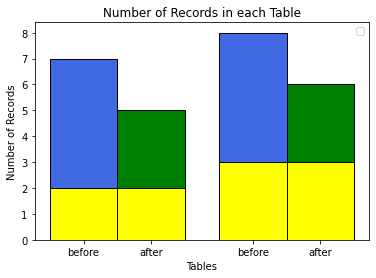

In [42]:
X = ['Table 3', 'Table 2']

fig, ax = plt.subplots()
X_axis = np.arange(len(X))

b = [7, 8]
a = [5, 6]
d = [2, 3]
width = 0.4
offset = width/2
xp = X_axis + offset
xn = X_axis - offset
xt = np.append(xn, xp)
xl1 = ['before'] * len(xn)
xl2 = ['after']* len(xn)


ax.bar(X_axis - offset, b, width, color=['royalblue'], edgecolor='black')
ax.bar(X_axis - offset, d, width, color=['yellow'], edgecolor='black')
ax.bar(X_axis + offset, a, width, color=['green'], edgecolor='black')
ax.bar(X_axis + offset, d, width, color=['yellow'], edgecolor='black')
#ax.bar(X_axis + offset, a, width, label = "increased", color=['green'], edgecolor='black')
#ax.bar(X_axis + offset, d, width, label = "decreased", color=['yellow'], edgecolor='black')

#ax.bar(X_axis + offset, d, width, label = "after", color=['Yellow'],bottom=a,edgecolor='black')

ax.set_xticks(xt, xl1+xl2)
ax.set_xlabel("Tables")
ax.set_ylabel("Number of Records")
ax.set_title("Number of Records in each Table")
ax.legend()

plt.show()

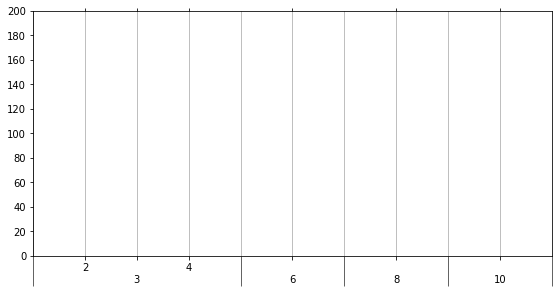

In [40]:
fig = plt.figure( figsize=(8, 4 ) )
ax = fig.add_axes( [.05, .1, .9, .85 ] )
ax.set_yticks( np.linspace(0, 200, 11 ) )

xticks = [ 2, 3, 4, 6, 8, 10 ]
xticks_minor = [ 1, 5, 7, 9, 11 ]
xlbls = [ 'background', '5 year statistical summary', 'future build',
          'maximum day', '90th percentile day', 'average day' ]

ax.set_xticks( xticks )
ax.set_xticks( xticks_minor, minor=True )
#ax.set_xticklabels( xlbls )
ax.set_xlim( 1, 11 )

ax.grid( 'off', axis='x' )
ax.grid( 'off', axis='x', which='minor' )

# vertical alignment of xtick labels
va = [ 0, -.05, 0, -.05, -.05, -.05 ]
for t, y in zip( ax.get_xticklabels( ), va ):
    t.set_y( y )

ax.tick_params( axis='x', which='minor', direction='out', length=30 )
ax.tick_params( axis='x', which='major', bottom='off', top='off' )

In [34]:
np.linspace(0, 200, 11 )

array([  0.,  20.,  40.,  60.,  80., 100., 120., 140., 160., 180., 200.])

In [104]:
increased_criteria = (result_df['before_date'] != '-') & (result_df['Difference (after - before)'] > 0)
decreased_criteria = (result_df['before_date'] != '-') & (result_df['Difference (after - before)'] < 0)
created_criteria = (result_df['before_date'] == '-') & (result_df['Difference (after - before)'] >= 0)
deleted_criteria = (result_df['after_date'] == '-') & (result_df['Difference (after - before)'] <= 0)

In [105]:
result_df['Class'] = "Unchanged"
result_df.loc[increased_criteria, "Class"] = "Increased"
result_df.loc[decreased_criteria, "Class"] = "Decreased"
result_df.loc[created_criteria, "Class"] = "Created"
result_df.loc[deleted_criteria, "Class"] = "Deleted"

In [109]:
#test_df = result_df['Class'].value_counts().to_frame()
#test_df = test_df.loc[test_df]
#result_df['Table'] = table_name
#result_df['Database'] = db_name
test_df = result_df.loc[result_df['Class'] != 'Unchanged', 'Class'].value_counts().to_frame()
test_df['Category'] = test_df.index
test_df

,Class,Category
Increased,1,Increased
Decreased,1,Decreased
Created,1,Created
Deleted,1,Deleted


In [25]:
# https://stackoverflow.com/questions/50560525/how-to-annotate-the-values-of-x-and-y-while-hovering-mouse-over-the-bar-graph/50560826#50560826
# https://stackoverflow.com/questions/7908636/how-to-add-hovering-annotations-in-matplotlib
# https://www.geeksforgeeks.org/plotting-multiple-bar-charts-using-matplotlib-in-python/
# https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_stacked.html
# https://matplotlib.org/stable/gallery/color/named_colors.html
# https://stackoverflow.com/questions/20532614/multiple-lines-of-x-tick-labels-in-matplotlib